# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.739735366967487 -2.766181168374078
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = targetQs[1:]
    #Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [28]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR3.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:0.0224 dloss:0.7102 dlossR:0.7102 dlossQ:0.6929
Episode:1 meanR:9.0000 rate:0.0180 gloss:-0.0286 dloss:0.6699 dlossR:0.6699 dlossQ:0.6928
Episode:2 meanR:9.3333 rate:0.0200 gloss:-0.0788 dloss:0.6304 dlossR:0.6304 dlossQ:0.6902
Episode:3 meanR:9.5000 rate:0.0200 gloss:-0.1307 dloss:0.5966 dlossR:0.5966 dlossQ:0.6858
Episode:4 meanR:11.8000 rate:0.0420 gloss:-0.1354 dloss:0.6045 dlossR:0.6045 dlossQ:0.6855
Episode:5 meanR:35.1667 rate:0.3040 gloss:-0.1472 dloss:0.6576 dlossR:0.6576 dlossQ:0.6871
Episode:6 meanR:32.7143 rate:0.0360 gloss:-0.1411 dloss:0.6055 dlossR:0.6055 dlossQ:0.6879
Episode:7 meanR:30.0000 rate:0.0220 gloss:-0.1873 dloss:0.5777 dlossR:0.5777 dlossQ:0.6839
Episode:8 meanR:27.7778 rate:0.0200 gloss:-0.2631 dloss:0.5377 dlossR:0.5377 dlossQ:0.6731
Episode:9 meanR:26.4000 rate:0.0280 gloss:-0.2238 dloss:0.5577 dlossR:0.5577 dlossQ:0.6802
Episode:10 meanR:26.7273 rate:0.0600 gloss:-0.2046 dloss:0.5746 dlossR:0.5746 dlossQ:0.6825
Epi

Episode:98 meanR:41.9192 rate:0.0380 gloss:-1.8535 dloss:0.1690 dlossR:0.1690 dlossQ:0.2404
Episode:99 meanR:41.7100 rate:0.0420 gloss:-1.9125 dloss:0.1800 dlossR:0.1800 dlossQ:0.2272
Episode:100 meanR:41.7700 rate:0.0300 gloss:-2.0516 dloss:0.1410 dlossR:0.1410 dlossQ:0.1988
Episode:101 meanR:42.4700 rate:0.1580 gloss:-1.7937 dloss:0.4839 dlossR:0.4839 dlossQ:0.2498
Episode:102 meanR:42.5900 rate:0.0440 gloss:-2.0829 dloss:0.1857 dlossR:0.1857 dlossQ:0.1979
Episode:103 meanR:43.0200 rate:0.1060 gloss:-1.8713 dloss:0.3527 dlossR:0.3527 dlossQ:0.2314
Episode:104 meanR:43.3600 rate:0.1100 gloss:-1.8971 dloss:0.3657 dlossR:0.3657 dlossQ:0.2249
Episode:105 meanR:42.2200 rate:0.0760 gloss:-1.9177 dloss:0.2719 dlossR:0.2719 dlossQ:0.2210
Episode:106 meanR:42.3800 rate:0.0680 gloss:-1.9541 dloss:0.2507 dlossR:0.2507 dlossQ:0.2121
Episode:107 meanR:42.5900 rate:0.0640 gloss:-2.0005 dloss:0.2400 dlossR:0.2400 dlossQ:0.2036
Episode:108 meanR:42.6600 rate:0.0340 gloss:-2.0732 dloss:0.1511 dlossR:

Episode:191 meanR:38.7500 rate:0.0480 gloss:-1.3002 dloss:0.2315 dlossR:0.2315 dlossQ:0.3891
Episode:192 meanR:38.8500 rate:0.0480 gloss:-1.2962 dloss:0.2318 dlossR:0.2318 dlossQ:0.3895
Episode:193 meanR:39.0000 rate:0.0480 gloss:-1.3442 dloss:0.2265 dlossR:0.2265 dlossQ:0.3740
Episode:194 meanR:39.1300 rate:0.0500 gloss:-1.4002 dloss:0.2255 dlossR:0.2255 dlossQ:0.3576
Episode:195 meanR:39.2500 rate:0.0460 gloss:-1.4124 dloss:0.2160 dlossR:0.2160 dlossQ:0.3541
Episode:196 meanR:39.3300 rate:0.0360 gloss:-1.4256 dloss:0.1941 dlossR:0.1941 dlossQ:0.3505
Episode:197 meanR:39.3700 rate:0.0380 gloss:-1.5489 dloss:0.1877 dlossR:0.1877 dlossQ:0.3159
Episode:198 meanR:39.3300 rate:0.0300 gloss:-1.6116 dloss:0.1651 dlossR:0.1651 dlossQ:0.2996
Episode:199 meanR:39.2900 rate:0.0340 gloss:-1.6432 dloss:0.1732 dlossR:0.1732 dlossQ:0.2927
Episode:200 meanR:39.2800 rate:0.0280 gloss:-1.7248 dloss:0.1533 dlossR:0.1533 dlossQ:0.2719
Episode:201 meanR:38.6200 rate:0.0260 gloss:-1.8087 dloss:0.1440 dloss

Episode:282 meanR:63.4800 rate:0.0300 gloss:-0.7460 dloss:0.3292 dlossR:0.3292 dlossQ:0.5672
Episode:283 meanR:64.3200 rate:0.1880 gloss:-0.6421 dloss:0.5084 dlossR:0.5084 dlossQ:0.5971
Episode:284 meanR:65.6900 rate:0.3620 gloss:-0.6448 dloss:0.6702 dlossR:0.6702 dlossQ:0.5962
Episode:285 meanR:70.1900 rate:1.0000 gloss:-0.6624 dloss:1.2829 dlossR:1.2829 dlossQ:0.5919
Episode:286 meanR:70.4500 rate:0.1540 gloss:-0.6361 dloss:0.4798 dlossR:0.4798 dlossQ:0.5976
Episode:287 meanR:71.7400 rate:0.3300 gloss:-0.6195 dloss:0.6394 dlossR:0.6394 dlossQ:0.6026
Episode:288 meanR:71.7500 rate:0.1040 gloss:-0.6391 dloss:0.4361 dlossR:0.4361 dlossQ:0.5965
Episode:289 meanR:71.7700 rate:0.0920 gloss:-0.6369 dloss:0.4250 dlossR:0.4250 dlossQ:0.5975
Episode:290 meanR:71.7700 rate:0.0960 gloss:-0.6402 dloss:0.4279 dlossR:0.4279 dlossQ:0.5964
Episode:291 meanR:72.0100 rate:0.0960 gloss:-0.6345 dloss:0.4289 dlossR:0.4289 dlossQ:0.5979
Episode:292 meanR:72.3100 rate:0.1080 gloss:-0.6325 dloss:0.4401 dloss

Episode:372 meanR:88.0700 rate:0.2600 gloss:-1.0412 dloss:0.5935 dlossR:0.5935 dlossQ:0.4752
Episode:373 meanR:83.8500 rate:0.1560 gloss:-0.9789 dloss:0.4389 dlossR:0.4389 dlossQ:0.4949
Episode:374 meanR:79.3100 rate:0.0920 gloss:-0.9726 dloss:0.3494 dlossR:0.3494 dlossQ:0.4962
Episode:375 meanR:78.2200 rate:0.0580 gloss:-0.9856 dloss:0.2984 dlossR:0.2984 dlossQ:0.4924
Episode:376 meanR:76.3000 rate:0.0360 gloss:-1.0750 dloss:0.2466 dlossR:0.2466 dlossQ:0.4640
Episode:377 meanR:75.2400 rate:0.0260 gloss:-1.1905 dloss:0.2100 dlossR:0.2100 dlossQ:0.4264
Episode:378 meanR:74.7500 rate:0.0300 gloss:-1.2910 dloss:0.2005 dlossR:0.2005 dlossQ:0.3943
Episode:379 meanR:74.4600 rate:0.0220 gloss:-1.3609 dloss:0.1775 dlossR:0.1775 dlossQ:0.3734
Episode:380 meanR:74.4800 rate:0.0240 gloss:-1.3432 dloss:0.1825 dlossR:0.1825 dlossQ:0.3789
Episode:381 meanR:74.4400 rate:0.0180 gloss:-1.4942 dloss:0.1552 dlossR:0.1552 dlossQ:0.3351
Episode:382 meanR:74.4100 rate:0.0240 gloss:-1.6401 dloss:0.1530 dloss

Episode:466 meanR:44.5200 rate:0.0380 gloss:-1.2472 dloss:0.2216 dlossR:0.2216 dlossQ:0.4081
Episode:467 meanR:44.6100 rate:0.0380 gloss:-1.2863 dloss:0.2161 dlossR:0.2161 dlossQ:0.3956
Episode:468 meanR:44.7200 rate:0.0400 gloss:-1.3290 dloss:0.2146 dlossR:0.2146 dlossQ:0.3827
Episode:469 meanR:44.7800 rate:0.0360 gloss:-1.3566 dloss:0.2037 dlossR:0.2037 dlossQ:0.3749
Episode:470 meanR:44.8500 rate:0.0380 gloss:-1.4051 dloss:0.2020 dlossR:0.2020 dlossQ:0.3599
Episode:471 meanR:44.9500 rate:0.0400 gloss:-1.4261 dloss:0.2042 dlossR:0.2042 dlossQ:0.3540
Episode:472 meanR:43.8300 rate:0.0360 gloss:-1.5149 dloss:0.1879 dlossR:0.1879 dlossQ:0.3279
Episode:473 meanR:43.2200 rate:0.0340 gloss:-1.5699 dloss:0.1795 dlossR:0.1795 dlossQ:0.3143
Episode:474 meanR:42.9800 rate:0.0440 gloss:-1.5429 dloss:0.2040 dlossR:0.2040 dlossQ:0.3245
Episode:475 meanR:42.8500 rate:0.0320 gloss:-1.5862 dloss:0.1743 dlossR:0.1743 dlossQ:0.3131
Episode:476 meanR:42.8700 rate:0.0400 gloss:-1.6446 dloss:0.1882 dloss

Episode:557 meanR:40.8500 rate:0.0200 gloss:-2.1505 dloss:0.1235 dlossR:0.1235 dlossQ:0.1946
Episode:558 meanR:40.5300 rate:0.0280 gloss:-1.9946 dloss:0.1445 dlossR:0.1445 dlossQ:0.2177
Episode:559 meanR:40.1400 rate:0.0220 gloss:-2.0889 dloss:0.1286 dlossR:0.1286 dlossQ:0.2041
Episode:560 meanR:44.7600 rate:1.0000 gloss:-1.3355 dloss:2.0665 dlossR:2.0665 dlossQ:0.3843
Episode:561 meanR:45.2500 rate:0.1500 gloss:-1.3826 dloss:0.4279 dlossR:0.4279 dlossQ:0.3678
Episode:562 meanR:45.3000 rate:0.0700 gloss:-1.3992 dloss:0.2675 dlossR:0.2675 dlossQ:0.3628
Episode:563 meanR:45.3200 rate:0.0560 gloss:-1.3540 dloss:0.2435 dlossR:0.2435 dlossQ:0.3770
Episode:564 meanR:45.3600 rate:0.0620 gloss:-1.3207 dloss:0.2586 dlossR:0.2586 dlossQ:0.3878
Episode:565 meanR:45.2500 rate:0.0400 gloss:-1.3813 dloss:0.2096 dlossR:0.2096 dlossQ:0.3692
Episode:566 meanR:45.2200 rate:0.0320 gloss:-1.3931 dloss:0.1934 dlossR:0.1934 dlossQ:0.3662
Episode:567 meanR:45.2200 rate:0.0380 gloss:-1.4061 dloss:0.2036 dloss

Episode:649 meanR:76.4600 rate:0.2500 gloss:-0.7762 dloss:0.5688 dlossR:0.5688 dlossQ:0.5590
Episode:650 meanR:78.6400 rate:0.4660 gloss:-0.7288 dloss:0.7937 dlossR:0.7937 dlossQ:0.5729
Episode:651 meanR:83.4600 rate:1.0000 gloss:-0.7251 dloss:1.3481 dlossR:1.3481 dlossQ:0.5745
Episode:652 meanR:83.6900 rate:0.0780 gloss:-0.8764 dloss:0.3607 dlossR:0.3607 dlossQ:0.5286
Episode:653 meanR:84.0800 rate:0.1300 gloss:-0.7766 dloss:0.4380 dlossR:0.4380 dlossQ:0.5575
Episode:654 meanR:84.0300 rate:0.0860 gloss:-0.8298 dloss:0.3797 dlossR:0.3797 dlossQ:0.5422
Episode:655 meanR:85.7800 rate:0.3700 gloss:-0.7484 dloss:0.6954 dlossR:0.6954 dlossQ:0.5670
Episode:656 meanR:85.7700 rate:0.0220 gloss:-1.1375 dloss:0.2360 dlossR:0.2360 dlossQ:0.4451
Episode:657 meanR:90.6700 rate:1.0000 gloss:-0.6757 dloss:1.2956 dlossR:1.2956 dlossQ:0.5882
Episode:658 meanR:90.7300 rate:0.0400 gloss:-0.9110 dloss:0.3134 dlossR:0.3134 dlossQ:0.5155
Episode:659 meanR:95.6200 rate:1.0000 gloss:-0.5473 dloss:1.1670 dloss

Episode:738 meanR:162.6300 rate:0.1300 gloss:-0.8522 dloss:0.4279 dlossR:0.4279 dlossQ:0.5384
Episode:739 meanR:160.1900 rate:0.1320 gloss:-0.9130 dloss:0.4265 dlossR:0.4265 dlossQ:0.5186
Episode:740 meanR:155.8000 rate:0.1220 gloss:-0.9453 dloss:0.4092 dlossR:0.4092 dlossQ:0.5089
Episode:741 meanR:155.6000 rate:0.1020 gloss:-1.0432 dloss:0.3753 dlossR:0.3753 dlossQ:0.4788
Episode:742 meanR:155.5500 rate:0.0360 gloss:-0.7502 dloss:0.3447 dlossR:0.3447 dlossQ:0.5703
Episode:743 meanR:155.4000 rate:0.0880 gloss:-1.1581 dloss:0.3428 dlossR:0.3428 dlossQ:0.4449
Episode:744 meanR:155.4200 rate:0.0280 gloss:-0.8553 dloss:0.3117 dlossR:0.3117 dlossQ:0.5398
Episode:745 meanR:155.7600 rate:0.1060 gloss:-1.1798 dloss:0.3627 dlossR:0.3627 dlossQ:0.4367
Episode:746 meanR:155.7900 rate:0.0320 gloss:-0.8875 dloss:0.3041 dlossR:0.3041 dlossQ:0.5290
Episode:747 meanR:155.8500 rate:0.0360 gloss:-0.9171 dloss:0.2988 dlossR:0.2988 dlossQ:0.5202
Episode:748 meanR:156.4400 rate:0.1400 gloss:-1.3658 dloss:0

Episode:829 meanR:93.0100 rate:0.2760 gloss:-0.7176 dloss:0.6132 dlossR:0.6132 dlossQ:0.5802
Episode:830 meanR:93.9800 rate:0.3560 gloss:-0.6303 dloss:0.6821 dlossR:0.6821 dlossQ:0.6075
Episode:831 meanR:96.3400 rate:0.6560 gloss:-0.5159 dloss:0.8952 dlossR:0.8952 dlossQ:0.6349
Episode:832 meanR:99.0800 rate:0.7220 gloss:-0.9367 dloss:1.2105 dlossR:1.2105 dlossQ:0.5148
Episode:833 meanR:98.6600 rate:0.0780 gloss:-0.8769 dloss:0.3857 dlossR:0.3857 dlossQ:0.5390
Episode:834 meanR:98.2300 rate:0.0800 gloss:-0.8184 dloss:0.3994 dlossR:0.3994 dlossQ:0.5549
Episode:835 meanR:99.3000 rate:0.3600 gloss:-0.8326 dloss:0.7045 dlossR:0.7045 dlossQ:0.5462
Episode:836 meanR:100.5700 rate:0.3900 gloss:-0.7931 dloss:0.7329 dlossR:0.7329 dlossQ:0.5576
Episode:837 meanR:101.8600 rate:0.3840 gloss:-0.8122 dloss:0.7271 dlossR:0.7271 dlossQ:0.5524
Episode:838 meanR:103.0200 rate:0.3620 gloss:-0.7820 dloss:0.6969 dlossR:0.6969 dlossQ:0.5607
Episode:839 meanR:103.6900 rate:0.2660 gloss:-0.8189 dloss:0.5900 d

Episode:917 meanR:165.1700 rate:1.0000 gloss:0.3387 dloss:0.4802 dlossR:0.4802 dlossQ:0.6643
Episode:918 meanR:166.6300 rate:0.5140 gloss:0.2651 dloss:0.7141 dlossR:0.7141 dlossQ:0.6751
Episode:919 meanR:167.7500 rate:0.2960 gloss:0.2891 dloss:0.8107 dlossR:0.8107 dlossQ:0.6692
Episode:920 meanR:167.6000 rate:0.0240 gloss:-0.5789 dloss:0.4804 dlossR:0.4804 dlossQ:0.5873
Episode:921 meanR:168.0400 rate:0.1280 gloss:0.2122 dloss:0.8516 dlossR:0.8516 dlossQ:0.6574
Episode:922 meanR:169.0800 rate:0.2620 gloss:0.3061 dloss:0.8398 dlossR:0.8398 dlossQ:0.6577
Episode:923 meanR:168.9300 rate:0.0220 gloss:-0.7279 dloss:0.4563 dlossR:0.4563 dlossQ:0.5377
Episode:924 meanR:170.3000 rate:0.3080 gloss:0.3740 dloss:0.8446 dlossR:0.8446 dlossQ:0.6511
Episode:925 meanR:171.7300 rate:0.3360 gloss:0.4014 dloss:0.8398 dlossR:0.8398 dlossQ:0.6464
Episode:926 meanR:173.8800 rate:0.4760 gloss:0.4360 dloss:0.7631 dlossR:0.7631 dlossQ:0.6419
Episode:927 meanR:176.5000 rate:0.5740 gloss:0.4005 dloss:0.6980 dlo

Episode:1005 meanR:278.7500 rate:0.1220 gloss:-0.1267 dloss:0.6365 dlossR:0.6365 dlossQ:0.6841
Episode:1006 meanR:274.3400 rate:0.1180 gloss:-0.0775 dloss:0.6587 dlossR:0.6587 dlossQ:0.6873
Episode:1007 meanR:269.9100 rate:0.1140 gloss:-0.1901 dloss:0.6067 dlossR:0.6067 dlossQ:0.6776
Episode:1008 meanR:265.4800 rate:0.1140 gloss:-0.1889 dloss:0.6080 dlossR:0.6080 dlossQ:0.6761
Episode:1009 meanR:260.9600 rate:0.0960 gloss:-0.2413 dloss:0.5804 dlossR:0.5804 dlossQ:0.6705
Episode:1010 meanR:256.9600 rate:0.2000 gloss:-0.1674 dloss:0.6367 dlossR:0.6367 dlossQ:0.6791
Episode:1011 meanR:252.4400 rate:0.0960 gloss:-0.3708 dloss:0.5247 dlossR:0.5247 dlossQ:0.6526
Episode:1012 meanR:248.1800 rate:0.1480 gloss:-0.2489 dloss:0.5941 dlossR:0.5941 dlossQ:0.6691
Episode:1013 meanR:243.8000 rate:0.1240 gloss:-0.3846 dloss:0.5348 dlossR:0.5348 dlossQ:0.6489
Episode:1014 meanR:239.4700 rate:0.1340 gloss:-0.4193 dloss:0.5270 dlossR:0.5270 dlossQ:0.6441
Episode:1015 meanR:235.0200 rate:0.1100 gloss:-0.4

Episode:1092 meanR:197.5500 rate:0.2420 gloss:0.0907 dloss:0.7321 dlossR:0.7321 dlossQ:0.6884
Episode:1093 meanR:194.8400 rate:0.2620 gloss:0.0791 dloss:0.7241 dlossR:0.7241 dlossQ:0.6898
Episode:1094 meanR:195.4400 rate:0.3180 gloss:0.0559 dloss:0.7109 dlossR:0.7109 dlossQ:0.6905
Episode:1095 meanR:195.3700 rate:0.3600 gloss:0.0519 dloss:0.7059 dlossR:0.7059 dlossQ:0.6912
Episode:1096 meanR:192.2800 rate:0.3820 gloss:0.0347 dloss:0.7013 dlossR:0.7013 dlossQ:0.6915
Episode:1097 meanR:193.7900 rate:0.4420 gloss:0.0311 dloss:0.6979 dlossR:0.6979 dlossQ:0.6914
Episode:1098 meanR:195.4100 rate:0.4560 gloss:0.0363 dloss:0.6975 dlossR:0.6975 dlossQ:0.6915
Episode:1099 meanR:197.1200 rate:0.4940 gloss:0.0298 dloss:0.6950 dlossR:0.6950 dlossQ:0.6919
Episode:1100 meanR:198.9600 rate:0.5160 gloss:0.0411 dloss:0.6939 dlossR:0.6939 dlossQ:0.6917
Episode:1101 meanR:203.3200 rate:1.0000 gloss:0.0585 dloss:0.6521 dlossR:0.6521 dlossQ:0.6921
Episode:1102 meanR:207.7600 rate:1.0000 gloss:0.0392 dloss:0

Episode:1180 meanR:245.6500 rate:0.1480 gloss:-0.4826 dloss:0.5251 dlossR:0.5251 dlossQ:0.6247
Episode:1181 meanR:245.1900 rate:0.1800 gloss:-0.4590 dloss:0.5571 dlossR:0.5571 dlossQ:0.6263
Episode:1182 meanR:245.0500 rate:0.2360 gloss:-0.4265 dloss:0.5853 dlossR:0.5853 dlossQ:0.6424
Episode:1183 meanR:244.9000 rate:0.2040 gloss:-0.4817 dloss:0.5668 dlossR:0.5668 dlossQ:0.6227
Episode:1184 meanR:245.5000 rate:0.3720 gloss:-0.3965 dloss:0.6754 dlossR:0.6754 dlossQ:0.6432
Episode:1185 meanR:245.3200 rate:0.1800 gloss:-0.6375 dloss:0.5173 dlossR:0.5173 dlossQ:0.5894
Episode:1186 meanR:246.2800 rate:0.4100 gloss:-0.4243 dloss:0.6956 dlossR:0.6956 dlossQ:0.6404
Episode:1187 meanR:246.0700 rate:0.1800 gloss:-0.6344 dloss:0.5119 dlossR:0.5119 dlossQ:0.5934
Episode:1188 meanR:246.0300 rate:0.2180 gloss:-0.5513 dloss:0.5604 dlossR:0.5604 dlossQ:0.6110
Episode:1189 meanR:245.7700 rate:0.1880 gloss:-0.6386 dloss:0.5212 dlossR:0.5212 dlossQ:0.5909
Episode:1190 meanR:245.2800 rate:0.1480 gloss:-0.7

Episode:1267 meanR:286.9200 rate:0.5500 gloss:0.1140 dloss:0.6967 dlossR:0.6967 dlossQ:0.6818
Episode:1268 meanR:288.3200 rate:0.4480 gloss:0.0892 dloss:0.7110 dlossR:0.7110 dlossQ:0.6826
Episode:1269 meanR:289.8700 rate:0.4780 gloss:0.1495 dloss:0.7065 dlossR:0.7065 dlossQ:0.6850
Episode:1270 meanR:290.6900 rate:0.3360 gloss:0.1437 dloss:0.7350 dlossR:0.7350 dlossQ:0.6859
Episode:1271 meanR:290.7800 rate:0.1700 gloss:-0.1982 dloss:0.6364 dlossR:0.6364 dlossQ:0.6592
Episode:1272 meanR:291.7600 rate:0.3600 gloss:0.0759 dloss:0.7161 dlossR:0.7161 dlossQ:0.6862
Episode:1273 meanR:291.8600 rate:0.1980 gloss:0.1477 dloss:0.7664 dlossR:0.7664 dlossQ:0.6853
Episode:1274 meanR:292.2700 rate:0.2120 gloss:0.0301 dloss:0.7129 dlossR:0.7129 dlossQ:0.6872
Episode:1275 meanR:292.7100 rate:0.2180 gloss:0.1333 dloss:0.7550 dlossR:0.7550 dlossQ:0.6864
Episode:1276 meanR:292.0500 rate:0.0380 gloss:0.1775 dloss:0.8266 dlossR:0.8266 dlossQ:0.6815
Episode:1277 meanR:293.1500 rate:0.3980 gloss:-0.3286 dloss

Episode:1363 meanR:128.6800 rate:0.0360 gloss:-0.9382 dloss:0.3153 dlossR:0.3153 dlossQ:0.5253
Episode:1364 meanR:126.0700 rate:0.0380 gloss:-0.9821 dloss:0.3068 dlossR:0.3068 dlossQ:0.5143
Episode:1365 meanR:124.9700 rate:0.0420 gloss:-1.0096 dloss:0.3047 dlossR:0.3047 dlossQ:0.5072
Episode:1366 meanR:123.6500 rate:0.0380 gloss:-1.0674 dloss:0.2893 dlossR:0.2893 dlossQ:0.4918
Episode:1367 meanR:121.1700 rate:0.0540 gloss:-1.0089 dloss:0.3167 dlossR:0.3167 dlossQ:0.5119
Episode:1368 meanR:119.2200 rate:0.0580 gloss:-0.9836 dloss:0.3297 dlossR:0.3297 dlossQ:0.5196
Episode:1369 meanR:117.1400 rate:0.0620 gloss:-1.0140 dloss:0.3307 dlossR:0.3307 dlossQ:0.5108
Episode:1370 meanR:115.9000 rate:0.0880 gloss:-1.0466 dloss:0.3682 dlossR:0.3682 dlossQ:0.4998
Episode:1371 meanR:115.6200 rate:0.1140 gloss:-1.0539 dloss:0.4113 dlossR:0.4113 dlossQ:0.5002
Episode:1372 meanR:114.6400 rate:0.1640 gloss:-1.2346 dloss:0.5080 dlossR:0.5080 dlossQ:0.4448
Episode:1373 meanR:115.9600 rate:0.4620 gloss:-0.7

Episode:1450 meanR:206.0700 rate:1.0000 gloss:0.1286 dloss:0.6047 dlossR:0.6047 dlossQ:0.6892
Episode:1451 meanR:206.9100 rate:1.0000 gloss:0.1126 dloss:0.6165 dlossR:0.6165 dlossQ:0.6908
Episode:1452 meanR:210.0900 rate:1.0000 gloss:0.1450 dloss:0.5940 dlossR:0.5940 dlossQ:0.6879
Episode:1453 meanR:213.9800 rate:1.0000 gloss:0.1532 dloss:0.5887 dlossR:0.5887 dlossQ:0.6873
Episode:1454 meanR:218.3800 rate:1.0000 gloss:0.1648 dloss:0.5812 dlossR:0.5812 dlossQ:0.6863
Episode:1455 meanR:223.0400 rate:1.0000 gloss:0.1734 dloss:0.5759 dlossR:0.5759 dlossQ:0.6855
Episode:1456 meanR:227.7700 rate:1.0000 gloss:0.1827 dloss:0.5699 dlossR:0.5699 dlossQ:0.6847
Episode:1457 meanR:232.5200 rate:1.0000 gloss:0.1947 dloss:0.5625 dlossR:0.5625 dlossQ:0.6835
Episode:1458 meanR:237.2300 rate:1.0000 gloss:0.2025 dloss:0.5579 dlossR:0.5579 dlossQ:0.6829
Episode:1459 meanR:242.0300 rate:1.0000 gloss:0.2083 dloss:0.5545 dlossR:0.5545 dlossQ:0.6824
Episode:1460 meanR:246.8200 rate:1.0000 gloss:0.2317 dloss:0

Episode:1537 meanR:251.2100 rate:0.1460 gloss:-0.5442 dloss:0.5204 dlossR:0.5204 dlossQ:0.6171
Episode:1538 meanR:250.0000 rate:0.1380 gloss:-0.5939 dloss:0.5063 dlossR:0.5063 dlossQ:0.6057
Episode:1539 meanR:248.4600 rate:0.1200 gloss:-0.6609 dloss:0.4803 dlossR:0.4803 dlossQ:0.5888
Episode:1540 meanR:246.5600 rate:0.1020 gloss:-0.6576 dloss:0.4640 dlossR:0.4640 dlossQ:0.5886
Episode:1541 meanR:244.4600 rate:0.1080 gloss:-0.6544 dloss:0.4687 dlossR:0.4687 dlossQ:0.5896
Episode:1542 meanR:242.1100 rate:0.0980 gloss:-0.7272 dloss:0.4429 dlossR:0.4429 dlossQ:0.5712
Episode:1543 meanR:239.2500 rate:0.1680 gloss:-0.5514 dloss:0.5439 dlossR:0.5439 dlossQ:0.6155
Episode:1544 meanR:235.9800 rate:0.1400 gloss:-0.5936 dloss:0.5126 dlossR:0.5126 dlossQ:0.6041
Episode:1545 meanR:232.0800 rate:0.1840 gloss:-0.5486 dloss:0.5510 dlossR:0.5510 dlossQ:0.6162
Episode:1546 meanR:228.0400 rate:0.1920 gloss:-0.5466 dloss:0.5560 dlossR:0.5560 dlossQ:0.6174
Episode:1547 meanR:224.3100 rate:0.2540 gloss:-0.4

Episode:1626 meanR:228.7000 rate:0.2560 gloss:-0.4703 dloss:0.6183 dlossR:0.6183 dlossQ:0.6214
Episode:1627 meanR:229.7200 rate:0.3540 gloss:-0.3176 dloss:0.6748 dlossR:0.6748 dlossQ:0.6551
Episode:1628 meanR:230.5000 rate:0.2960 gloss:-0.4406 dloss:0.6536 dlossR:0.6536 dlossQ:0.6219
Episode:1629 meanR:231.0100 rate:0.2800 gloss:-0.4879 dloss:0.6337 dlossR:0.6337 dlossQ:0.6168
Episode:1630 meanR:231.3500 rate:0.2640 gloss:-0.4259 dloss:0.6182 dlossR:0.6182 dlossQ:0.6366
Episode:1631 meanR:231.6300 rate:0.2780 gloss:-0.5333 dloss:0.6255 dlossR:0.6255 dlossQ:0.6114
Episode:1632 meanR:231.2600 rate:0.2360 gloss:-0.5637 dloss:0.5970 dlossR:0.5970 dlossQ:0.6000
Episode:1633 meanR:231.0700 rate:0.3260 gloss:-0.4396 dloss:0.6550 dlossR:0.6550 dlossQ:0.6349
Episode:1634 meanR:227.8300 rate:0.3520 gloss:-0.4251 dloss:0.6756 dlossR:0.6756 dlossQ:0.6346
Episode:1635 meanR:224.0600 rate:0.2460 gloss:-0.5566 dloss:0.5918 dlossR:0.5918 dlossQ:0.6102
Episode:1636 meanR:222.7100 rate:0.2440 gloss:-0.6

Episode:1716 meanR:150.3600 rate:0.0240 gloss:-0.9693 dloss:0.3188 dlossR:0.3188 dlossQ:0.5031
Episode:1717 meanR:147.9800 rate:0.0320 gloss:-0.8291 dloss:0.3504 dlossR:0.3504 dlossQ:0.5426
Episode:1718 meanR:146.9100 rate:0.0260 gloss:-0.9890 dloss:0.3160 dlossR:0.3160 dlossQ:0.4951
Episode:1719 meanR:145.7300 rate:0.0300 gloss:-0.8683 dloss:0.3333 dlossR:0.3333 dlossQ:0.5375
Episode:1720 meanR:144.3000 rate:0.0260 gloss:-0.9561 dloss:0.3150 dlossR:0.3150 dlossQ:0.5120
Episode:1721 meanR:142.9500 rate:0.0260 gloss:-1.1388 dloss:0.2840 dlossR:0.2840 dlossQ:0.4529
Episode:1722 meanR:141.8100 rate:0.0280 gloss:-1.2202 dloss:0.2694 dlossR:0.2694 dlossQ:0.4299
Episode:1723 meanR:140.3700 rate:0.0280 gloss:-1.1713 dloss:0.2758 dlossR:0.2758 dlossQ:0.4463
Episode:1724 meanR:139.1000 rate:0.0300 gloss:-1.3995 dloss:0.2578 dlossR:0.2578 dlossQ:0.3867
Episode:1725 meanR:138.1300 rate:0.0500 gloss:-0.9065 dloss:0.3326 dlossR:0.3326 dlossQ:0.5361
Episode:1726 meanR:137.5300 rate:0.1360 gloss:-1.2

Episode:1803 meanR:292.6200 rate:1.0000 gloss:0.9473 dloss:0.2308 dlossR:0.2308 dlossQ:0.5051
Episode:1804 meanR:297.5300 rate:1.0000 gloss:1.0074 dloss:0.2109 dlossR:0.2109 dlossQ:0.4853
Episode:1805 meanR:298.5000 rate:1.0000 gloss:1.0915 dloss:0.1879 dlossR:0.1879 dlossQ:0.4579
Episode:1806 meanR:298.5000 rate:1.0000 gloss:1.2090 dloss:0.1622 dlossR:0.1622 dlossQ:0.4206
Episode:1807 meanR:300.0600 rate:1.0000 gloss:1.3281 dloss:0.1379 dlossR:0.1379 dlossQ:0.3830
Episode:1808 meanR:303.5400 rate:1.0000 gloss:1.2836 dloss:0.1456 dlossR:0.1456 dlossQ:0.3965
Episode:1809 meanR:304.2500 rate:0.6380 gloss:1.8993 dloss:1.0662 dlossR:1.0662 dlossQ:0.2433
Episode:1810 meanR:305.2200 rate:0.3620 gloss:1.5079 dloss:1.5007 dlossR:1.5007 dlossQ:0.3321
Episode:1811 meanR:305.5500 rate:0.2360 gloss:1.2034 dloss:1.4958 dlossR:1.4958 dlossQ:0.4224
Episode:1812 meanR:306.2700 rate:0.1960 gloss:0.9927 dloss:1.3882 dlossR:1.3882 dlossQ:0.4848
Episode:1813 meanR:307.9100 rate:0.3620 gloss:1.4878 dloss:1

Episode:1890 meanR:210.9200 rate:0.2900 gloss:-0.8678 dloss:0.6435 dlossR:0.6435 dlossQ:0.5302
Episode:1891 meanR:206.6600 rate:0.1480 gloss:-1.1391 dloss:0.4513 dlossR:0.4513 dlossQ:0.4549
Episode:1892 meanR:206.6600 rate:1.0000 gloss:-0.4156 dloss:1.0397 dlossR:1.0397 dlossQ:0.6520
Episode:1893 meanR:204.0700 rate:0.4820 gloss:-0.6386 dloss:0.8017 dlossR:0.8017 dlossQ:0.5941
Episode:1894 meanR:200.5400 rate:0.2940 gloss:-0.7565 dloss:0.6321 dlossR:0.6321 dlossQ:0.5621
Episode:1895 meanR:197.5300 rate:0.3980 gloss:-0.6898 dloss:0.7319 dlossR:0.7319 dlossQ:0.5792
Episode:1896 meanR:197.5300 rate:1.0000 gloss:-0.3144 dloss:0.9476 dlossR:0.9476 dlossQ:0.6702
Episode:1897 meanR:196.8200 rate:0.8580 gloss:-0.4512 dloss:0.9929 dlossR:0.9929 dlossQ:0.6380
Episode:1898 meanR:197.6700 rate:0.9640 gloss:-0.2250 dloss:0.8642 dlossR:0.8642 dlossQ:0.6793
Episode:1899 meanR:197.6700 rate:1.0000 gloss:-0.2672 dloss:0.9054 dlossR:0.9054 dlossQ:0.6763
Episode:1900 meanR:195.4900 rate:0.5640 gloss:-0.1

Episode:1978 meanR:275.8500 rate:0.3880 gloss:-0.0914 dloss:0.6984 dlossR:0.6984 dlossQ:0.6759
Episode:1979 meanR:276.5800 rate:0.3120 gloss:-0.1642 dloss:0.6727 dlossR:0.6727 dlossQ:0.6724
Episode:1980 meanR:277.3400 rate:0.2580 gloss:-0.2598 dloss:0.6414 dlossR:0.6414 dlossQ:0.6597
Episode:1981 meanR:279.0700 rate:0.4580 gloss:-0.0668 dloss:0.7155 dlossR:0.7155 dlossQ:0.6693
Episode:1982 meanR:279.5100 rate:0.2140 gloss:-0.3602 dloss:0.6030 dlossR:0.6030 dlossQ:0.6435
Episode:1983 meanR:281.2600 rate:0.5120 gloss:-0.0266 dloss:0.7160 dlossR:0.7160 dlossQ:0.6741
Episode:1984 meanR:282.5600 rate:0.4520 gloss:-0.1061 dloss:0.7128 dlossR:0.7128 dlossQ:0.6689
Episode:1985 meanR:284.5100 rate:0.5980 gloss:-0.0159 dloss:0.7132 dlossR:0.7132 dlossQ:0.6778
Episode:1986 meanR:281.8000 rate:0.4580 gloss:-0.1290 dloss:0.7159 dlossR:0.7159 dlossQ:0.6660
Episode:1987 meanR:280.7200 rate:0.4280 gloss:-0.1319 dloss:0.7031 dlossR:0.7031 dlossQ:0.6725
Episode:1988 meanR:281.6300 rate:0.3900 gloss:-0.1

Episode:2066 meanR:208.9300 rate:0.3140 gloss:-0.3323 dloss:0.6638 dlossR:0.6638 dlossQ:0.6438
Episode:2067 meanR:208.4700 rate:0.2980 gloss:-0.2882 dloss:0.6451 dlossR:0.6451 dlossQ:0.6612
Episode:2068 meanR:204.8400 rate:0.2740 gloss:-0.3675 dloss:0.6235 dlossR:0.6235 dlossQ:0.6495
Episode:2069 meanR:204.2100 rate:0.2700 gloss:-0.3979 dloss:0.6214 dlossR:0.6214 dlossQ:0.6417
Episode:2070 meanR:204.5900 rate:0.3120 gloss:-0.3906 dloss:0.6497 dlossR:0.6497 dlossQ:0.6405
Episode:2071 meanR:204.6200 rate:0.3340 gloss:-0.3929 dloss:0.6732 dlossR:0.6732 dlossQ:0.6321
Episode:2072 meanR:204.8700 rate:0.3120 gloss:-0.5759 dloss:0.6628 dlossR:0.6628 dlossQ:0.5953
Episode:2073 meanR:205.5400 rate:0.3580 gloss:-0.3724 dloss:0.6860 dlossR:0.6860 dlossQ:0.6349
Episode:2074 meanR:205.6500 rate:0.3000 gloss:-0.2940 dloss:0.6531 dlossR:0.6531 dlossQ:0.6534
Episode:2075 meanR:205.1100 rate:0.2140 gloss:-0.4889 dloss:0.5661 dlossR:0.5661 dlossQ:0.6277
Episode:2076 meanR:204.9000 rate:0.2520 gloss:-0.3

Episode:2153 meanR:241.4700 rate:1.0000 gloss:0.6331 dloss:0.4397 dlossR:0.4397 dlossQ:0.5233
Episode:2154 meanR:241.5000 rate:0.3560 gloss:0.9123 dloss:1.0955 dlossR:1.0955 dlossQ:0.5139
Episode:2155 meanR:245.2600 rate:1.0000 gloss:1.1920 dloss:0.1762 dlossR:0.1762 dlossQ:0.4242
Episode:2156 meanR:245.3500 rate:0.3180 gloss:0.9092 dloss:1.1459 dlossR:1.1459 dlossQ:0.5145
Episode:2157 meanR:245.5000 rate:0.2380 gloss:0.5457 dloss:0.9888 dlossR:0.9888 dlossQ:0.6137
Episode:2158 meanR:245.2100 rate:0.2100 gloss:0.4845 dloss:0.9767 dlossR:0.9767 dlossQ:0.6223
Episode:2159 meanR:245.1500 rate:0.2820 gloss:0.5788 dloss:0.9736 dlossR:0.9736 dlossQ:0.6055
Episode:2160 meanR:244.3400 rate:0.2320 gloss:0.4968 dloss:0.9631 dlossR:0.9631 dlossQ:0.6247
Episode:2161 meanR:244.6000 rate:0.3140 gloss:0.4942 dloss:0.9046 dlossR:0.9046 dlossQ:0.6227
Episode:2162 meanR:244.5500 rate:0.2640 gloss:0.4871 dloss:0.9439 dlossR:0.9439 dlossQ:0.6178
Episode:2163 meanR:244.0700 rate:0.2820 gloss:0.4724 dloss:0

Episode:2240 meanR:301.0100 rate:0.8660 gloss:0.2198 dloss:0.5986 dlossR:0.5986 dlossQ:0.6700
Episode:2241 meanR:300.4100 rate:0.7900 gloss:0.2084 dloss:0.6270 dlossR:0.6270 dlossQ:0.6710
Episode:2242 meanR:300.4100 rate:1.0000 gloss:0.3639 dloss:0.4628 dlossR:0.4628 dlossQ:0.6575
Episode:2243 meanR:299.6000 rate:0.8380 gloss:0.2106 dloss:0.6118 dlossR:0.6118 dlossQ:0.6714
Episode:2244 meanR:297.4700 rate:0.5740 gloss:0.1903 dloss:0.7089 dlossR:0.7089 dlossQ:0.6604
Episode:2245 meanR:297.4700 rate:1.0000 gloss:0.3329 dloss:0.4873 dlossR:0.4873 dlossQ:0.6568
Episode:2246 meanR:295.8500 rate:0.5980 gloss:0.1512 dloss:0.7162 dlossR:0.7162 dlossQ:0.6533
Episode:2247 meanR:293.9100 rate:0.6120 gloss:0.1601 dloss:0.7324 dlossR:0.7324 dlossQ:0.6356
Episode:2248 meanR:291.9900 rate:0.6160 gloss:0.2442 dloss:0.7010 dlossR:0.7010 dlossQ:0.6489
Episode:2249 meanR:289.7200 rate:0.5460 gloss:0.0267 dloss:0.7333 dlossR:0.7333 dlossQ:0.6578
Episode:2250 meanR:287.7400 rate:0.3420 gloss:-0.1698 dloss:

Episode:2328 meanR:322.0900 rate:0.7220 gloss:0.1611 dloss:0.6456 dlossR:0.6456 dlossQ:0.6513
Episode:2329 meanR:320.4600 rate:0.4060 gloss:0.1750 dloss:0.7821 dlossR:0.7821 dlossQ:0.6600
Episode:2330 meanR:320.0300 rate:0.4060 gloss:0.1423 dloss:0.7706 dlossR:0.7706 dlossQ:0.6656
Episode:2331 meanR:323.6100 rate:1.0000 gloss:0.1619 dloss:0.4894 dlossR:0.4894 dlossQ:0.6644
Episode:2332 meanR:324.5200 rate:0.4160 gloss:0.1313 dloss:0.7600 dlossR:0.7600 dlossQ:0.6670
Episode:2333 meanR:323.8900 rate:0.4300 gloss:0.1412 dloss:0.7609 dlossR:0.7609 dlossQ:0.6628
Episode:2334 meanR:325.6800 rate:1.0000 gloss:0.2140 dloss:0.4362 dlossR:0.4362 dlossQ:0.6403
Episode:2335 meanR:324.0000 rate:0.3720 gloss:0.0816 dloss:0.7466 dlossR:0.7466 dlossQ:0.6817
Episode:2336 meanR:320.7700 rate:0.3540 gloss:0.0747 dloss:0.7522 dlossR:0.7522 dlossQ:0.6808
Episode:2337 meanR:317.8200 rate:0.4100 gloss:0.0728 dloss:0.7382 dlossR:0.7382 dlossQ:0.6809
Episode:2338 meanR:314.3300 rate:0.3020 gloss:0.0268 dloss:0

Episode:2415 meanR:301.4400 rate:1.0000 gloss:0.3231 dloss:0.2934 dlossR:0.2934 dlossQ:0.5687
Episode:2416 meanR:302.0800 rate:1.0000 gloss:0.3631 dloss:0.2718 dlossR:0.2718 dlossQ:0.5508
Episode:2417 meanR:303.7500 rate:1.0000 gloss:0.4432 dloss:0.2491 dlossR:0.2491 dlossQ:0.5310
Episode:2418 meanR:305.0200 rate:1.0000 gloss:0.3487 dloss:0.2365 dlossR:0.2365 dlossQ:0.5186
Episode:2419 meanR:305.0200 rate:1.0000 gloss:0.4148 dloss:0.2111 dlossR:0.2111 dlossQ:0.4906
Episode:2420 meanR:305.0200 rate:1.0000 gloss:0.3983 dloss:0.1899 dlossR:0.1899 dlossQ:0.4681
Episode:2421 meanR:307.8900 rate:1.0000 gloss:0.4331 dloss:0.1636 dlossR:0.1636 dlossQ:0.4303
Episode:2422 meanR:311.3100 rate:1.0000 gloss:0.5566 dloss:0.1279 dlossR:0.1279 dlossQ:0.3707
Episode:2423 meanR:313.5200 rate:0.8500 gloss:0.4856 dloss:0.4424 dlossR:0.4424 dlossQ:0.3432
Episode:2424 meanR:315.7500 rate:0.8060 gloss:0.6227 dloss:0.5620 dlossR:0.5620 dlossQ:0.3090
Episode:2425 meanR:317.1200 rate:0.5400 gloss:0.3389 dloss:1

Episode:2502 meanR:323.3400 rate:0.6260 gloss:-0.0332 dloss:0.7350 dlossR:0.7350 dlossQ:0.7128
Episode:2503 meanR:322.7500 rate:0.4440 gloss:-0.0255 dloss:0.6951 dlossR:0.6951 dlossQ:0.7091
Episode:2504 meanR:321.8800 rate:0.5360 gloss:-0.0257 dloss:0.7053 dlossR:0.7053 dlossQ:0.7093
Episode:2505 meanR:322.7600 rate:0.8140 gloss:-0.0154 dloss:0.7147 dlossR:0.7147 dlossQ:0.7073
Episode:2506 meanR:321.0500 rate:0.5040 gloss:-0.0159 dloss:0.6983 dlossR:0.6983 dlossQ:0.7047
Episode:2507 meanR:319.2100 rate:0.5560 gloss:-0.0121 dloss:0.6973 dlossR:0.6973 dlossQ:0.7024
Episode:2508 meanR:319.5300 rate:0.6960 gloss:-0.0073 dloss:0.6882 dlossR:0.6882 dlossQ:0.7019
Episode:2509 meanR:318.0500 rate:0.7040 gloss:-0.0050 dloss:0.6831 dlossR:0.6831 dlossQ:0.7002
Episode:2510 meanR:315.6800 rate:0.4660 gloss:-0.0035 dloss:0.6992 dlossR:0.6992 dlossQ:0.6970
Episode:2511 meanR:312.9100 rate:0.4460 gloss:0.0000 dloss:0.7050 dlossR:0.7050 dlossQ:0.6973
Episode:2512 meanR:311.6700 rate:0.7520 gloss:0.002

Episode:2589 meanR:286.3000 rate:1.0000 gloss:0.0207 dloss:0.5498 dlossR:0.5498 dlossQ:0.6840
Episode:2590 meanR:289.4800 rate:1.0000 gloss:0.0283 dloss:0.5416 dlossR:0.5416 dlossQ:0.6823
Episode:2591 meanR:292.6800 rate:1.0000 gloss:0.0284 dloss:0.5301 dlossR:0.5301 dlossQ:0.6806
Episode:2592 meanR:295.7800 rate:1.0000 gloss:0.0338 dloss:0.5266 dlossR:0.5266 dlossQ:0.6798
Episode:2593 meanR:298.7600 rate:1.0000 gloss:0.0355 dloss:0.5152 dlossR:0.5152 dlossQ:0.6778
Episode:2594 meanR:301.3600 rate:1.0000 gloss:0.0439 dloss:0.5058 dlossR:0.5058 dlossQ:0.6753
Episode:2595 meanR:303.4400 rate:1.0000 gloss:0.0397 dloss:0.4973 dlossR:0.4973 dlossQ:0.6749
Episode:2596 meanR:305.7200 rate:1.0000 gloss:0.0524 dloss:0.4835 dlossR:0.4835 dlossQ:0.6717
Episode:2597 meanR:308.5100 rate:1.0000 gloss:0.0528 dloss:0.4746 dlossR:0.4746 dlossQ:0.6693
Episode:2598 meanR:311.5500 rate:1.0000 gloss:0.0522 dloss:0.4649 dlossR:0.4649 dlossQ:0.6689
Episode:2599 meanR:313.4700 rate:1.0000 gloss:0.0572 dloss:0

Episode:2682 meanR:158.2900 rate:0.0300 gloss:-0.5688 dloss:0.1600 dlossR:0.1600 dlossQ:0.2961
Episode:2683 meanR:153.4300 rate:0.0280 gloss:-0.5309 dloss:0.1543 dlossR:0.1543 dlossQ:0.2969
Episode:2684 meanR:148.5600 rate:0.0260 gloss:-0.6879 dloss:0.1479 dlossR:0.1479 dlossQ:0.2895
Episode:2685 meanR:143.7200 rate:0.0320 gloss:-0.4967 dloss:0.1672 dlossR:0.1672 dlossQ:0.3074
Episode:2686 meanR:138.8500 rate:0.0260 gloss:-0.4898 dloss:0.1590 dlossR:0.1590 dlossQ:0.3318
Episode:2687 meanR:134.0300 rate:0.0360 gloss:-0.6257 dloss:0.1777 dlossR:0.1777 dlossQ:0.3076
Episode:2688 meanR:129.2100 rate:0.0360 gloss:-0.5539 dloss:0.1829 dlossR:0.1829 dlossQ:0.3261
Episode:2689 meanR:124.4100 rate:0.0400 gloss:-0.5912 dloss:0.1906 dlossR:0.1906 dlossQ:0.3190
Episode:2690 meanR:119.5700 rate:0.0320 gloss:-0.6287 dloss:0.1718 dlossR:0.1718 dlossQ:0.3241
Episode:2691 meanR:114.7400 rate:0.0340 gloss:-0.5700 dloss:0.1776 dlossR:0.1776 dlossQ:0.3295
Episode:2692 meanR:109.9400 rate:0.0400 gloss:-0.6

Episode:2770 meanR:234.4700 rate:1.0000 gloss:0.3451 dloss:0.2370 dlossR:0.2370 dlossQ:0.5118
Episode:2771 meanR:238.6500 rate:0.8620 gloss:0.3260 dloss:0.4424 dlossR:0.4424 dlossQ:0.5304
Episode:2772 meanR:243.5400 rate:1.0000 gloss:0.2855 dloss:0.2795 dlossR:0.2795 dlossQ:0.5528
Episode:2773 meanR:248.4200 rate:1.0000 gloss:0.3282 dloss:0.2583 dlossR:0.2583 dlossQ:0.5348
Episode:2774 meanR:253.2900 rate:1.0000 gloss:0.2054 dloss:0.3283 dlossR:0.3283 dlossQ:0.5978
Episode:2775 meanR:258.1600 rate:1.0000 gloss:0.3181 dloss:0.2689 dlossR:0.2689 dlossQ:0.5483
Episode:2776 meanR:263.0300 rate:1.0000 gloss:0.3186 dloss:0.2581 dlossR:0.2581 dlossQ:0.5349
Episode:2777 meanR:267.9300 rate:1.0000 gloss:0.3355 dloss:0.2542 dlossR:0.2542 dlossQ:0.5311
Episode:2778 meanR:272.8100 rate:1.0000 gloss:0.2339 dloss:0.3007 dlossR:0.3007 dlossQ:0.5823
Episode:2779 meanR:277.6700 rate:1.0000 gloss:0.2716 dloss:0.2756 dlossR:0.2756 dlossQ:0.5526
Episode:2780 meanR:282.5300 rate:1.0000 gloss:0.1701 dloss:0

Episode:2858 meanR:482.1200 rate:1.0000 gloss:1.1874 dloss:0.0507 dlossR:0.0507 dlossQ:0.2334
Episode:2859 meanR:483.4500 rate:1.0000 gloss:1.7291 dloss:0.0376 dlossR:0.0376 dlossQ:0.2257
Episode:2860 meanR:485.3700 rate:1.0000 gloss:1.5692 dloss:0.0223 dlossR:0.0223 dlossQ:0.1454
Episode:2861 meanR:486.5900 rate:1.0000 gloss:1.8519 dloss:0.0151 dlossR:0.0151 dlossQ:0.1007
Episode:2862 meanR:488.5100 rate:1.0000 gloss:1.7890 dloss:0.0333 dlossR:0.0333 dlossQ:0.2093
Episode:2863 meanR:490.2100 rate:1.0000 gloss:1.7964 dloss:0.0324 dlossR:0.0324 dlossQ:0.2050
Episode:2864 meanR:492.1100 rate:1.0000 gloss:1.9191 dloss:0.0119 dlossR:0.0119 dlossQ:0.0811
Episode:2865 meanR:493.6000 rate:1.0000 gloss:1.6130 dloss:0.0344 dlossR:0.0344 dlossQ:0.2119
Episode:2866 meanR:494.1700 rate:1.0000 gloss:1.8529 dloss:0.0316 dlossR:0.0316 dlossQ:0.2051
Episode:2867 meanR:494.1700 rate:1.0000 gloss:1.9815 dloss:0.0223 dlossR:0.0223 dlossQ:0.1543
Episode:2868 meanR:494.2000 rate:1.0000 gloss:1.9246 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

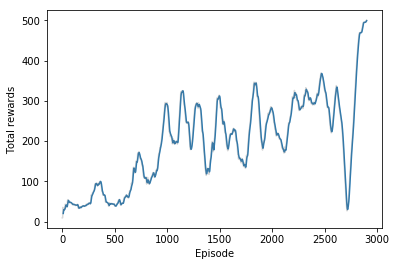

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

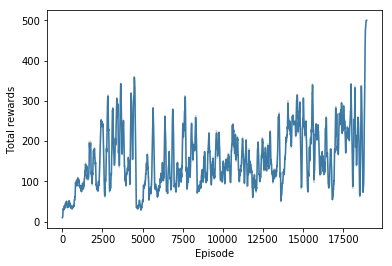

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

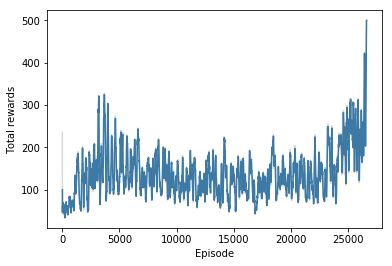

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

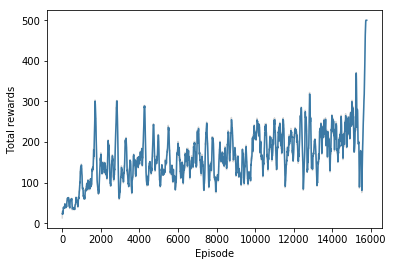

In [44]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

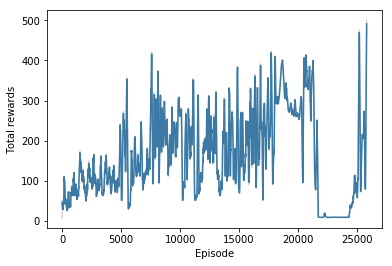

In [42]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

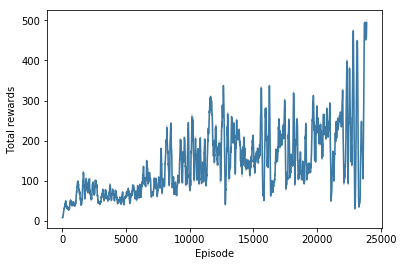

In [40]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

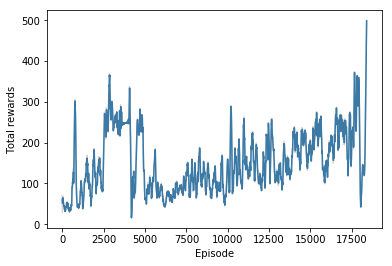

In [37]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

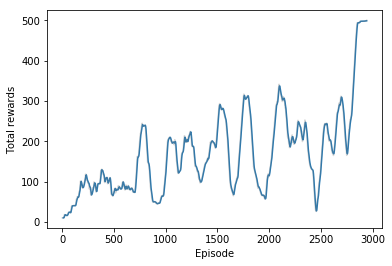

In [221]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

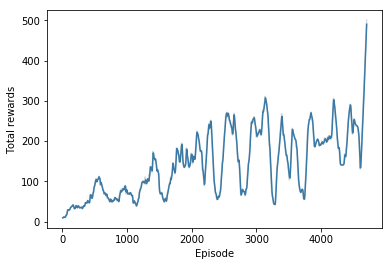

In [216]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

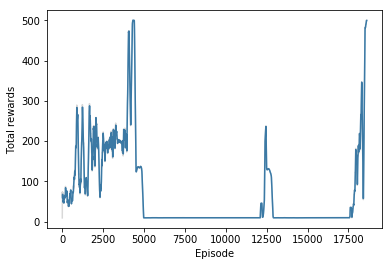

In [203]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

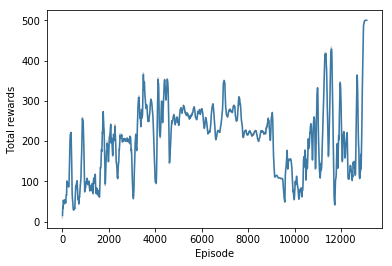

In [188]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

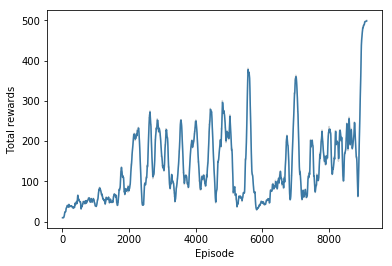

In [165]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

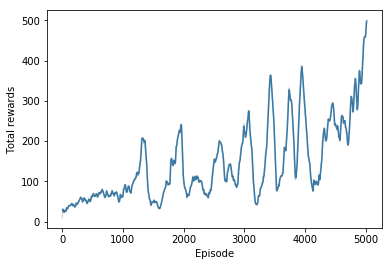

In [126]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

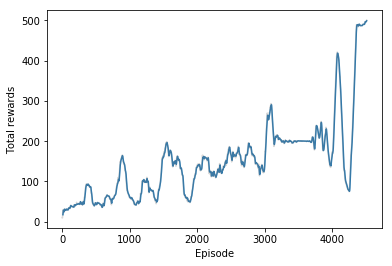

In [109]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

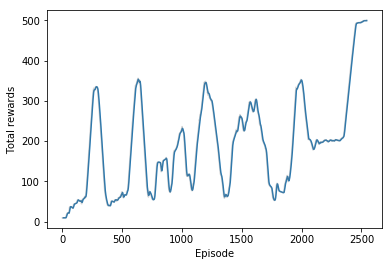

In [84]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

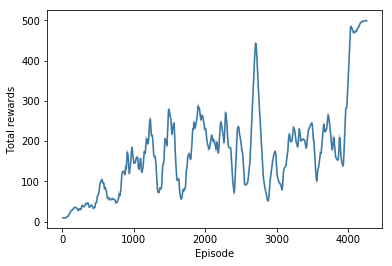

In [64]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

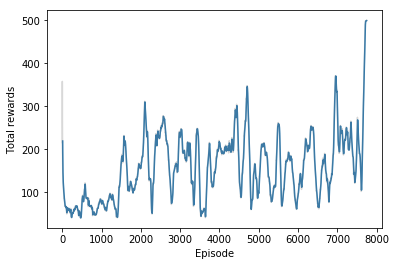

In [44]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

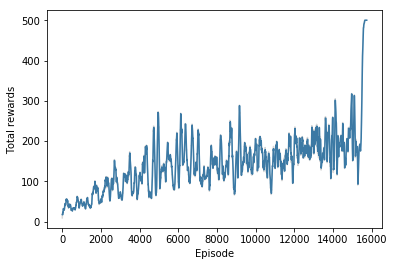

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

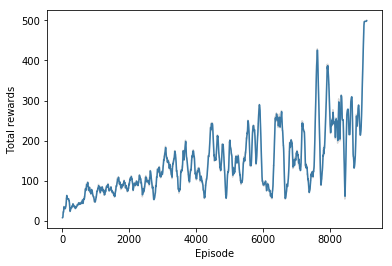

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

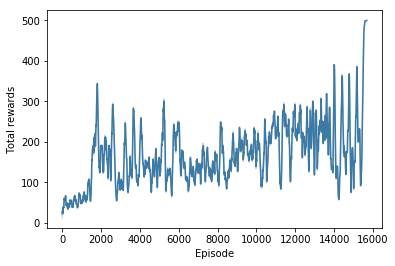

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

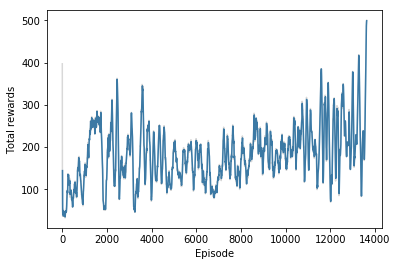

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

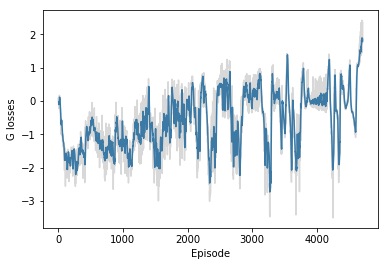

In [215]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

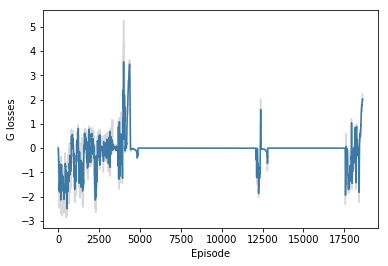

In [204]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

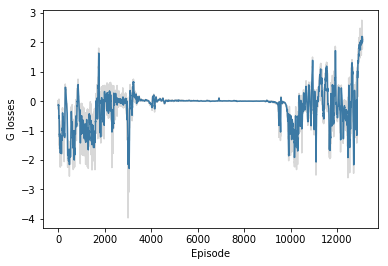

In [189]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

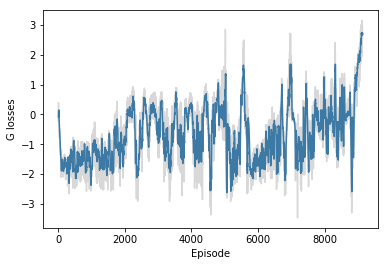

In [166]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

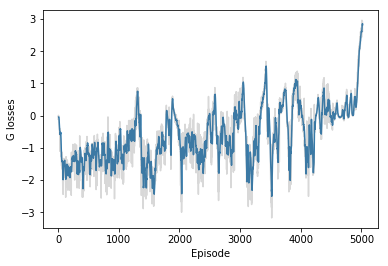

In [129]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

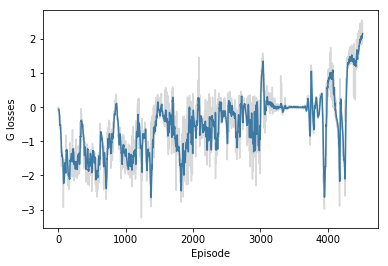

In [110]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

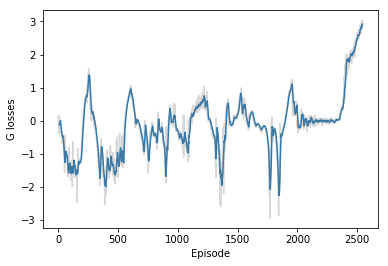

In [85]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

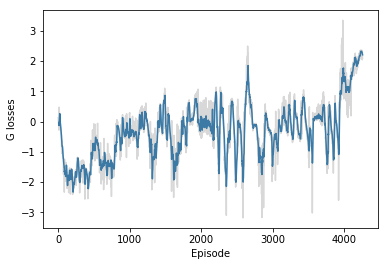

In [65]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

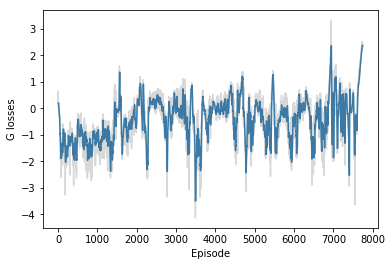

In [45]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

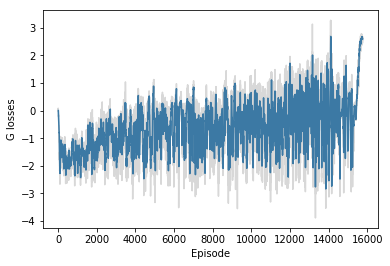

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

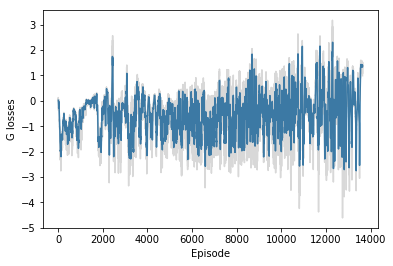

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

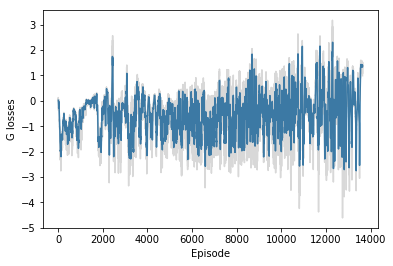

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

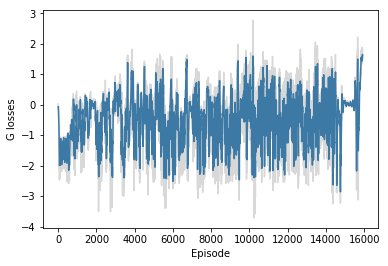
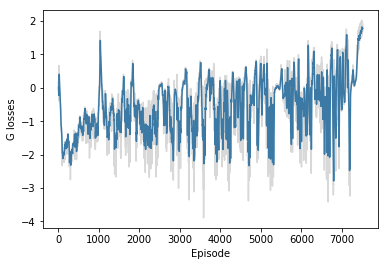

Text(0,0.5,'D losses')

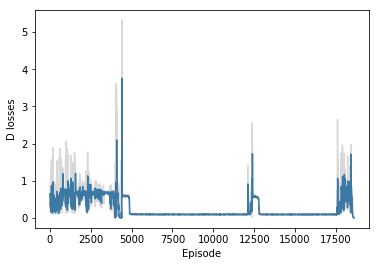

In [205]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

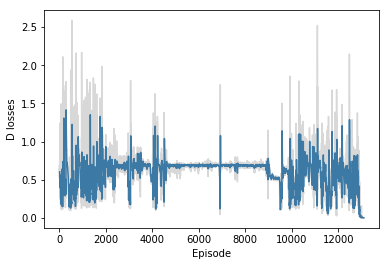

In [190]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

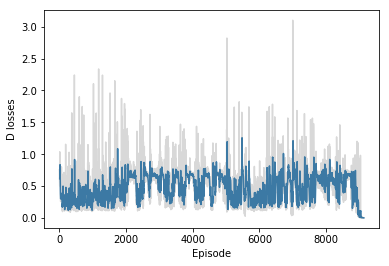

In [167]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

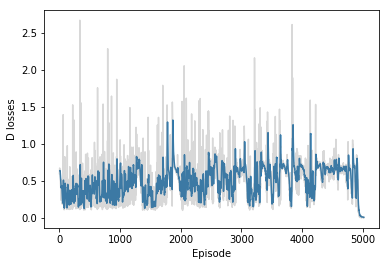

In [130]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

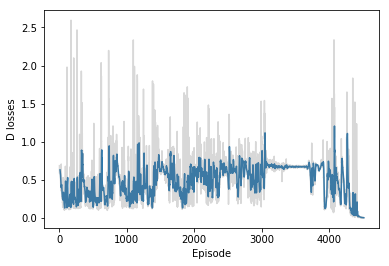

In [111]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

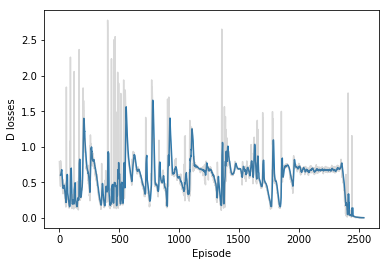

In [86]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

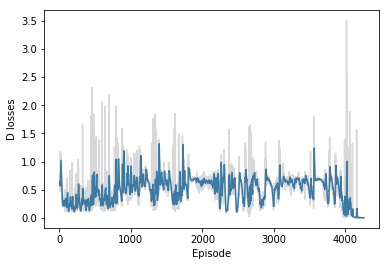

In [66]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

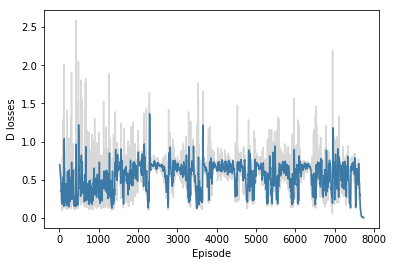

In [46]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

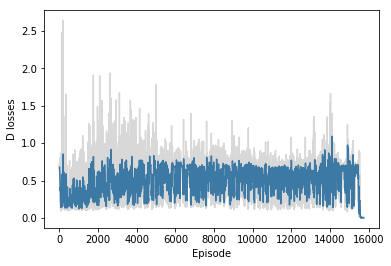

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

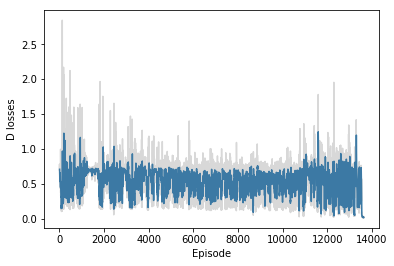

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

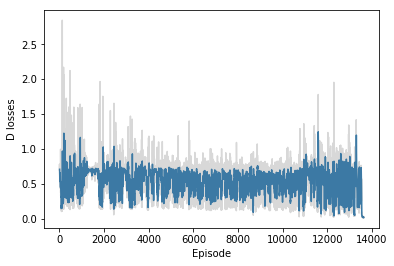

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

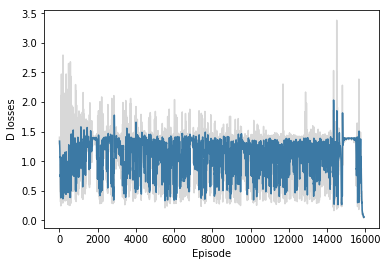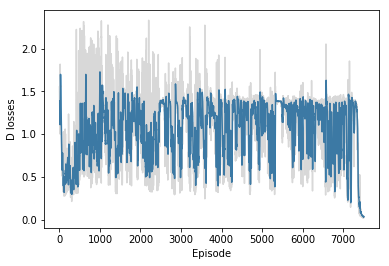

Text(0,0.5,'D losses R')

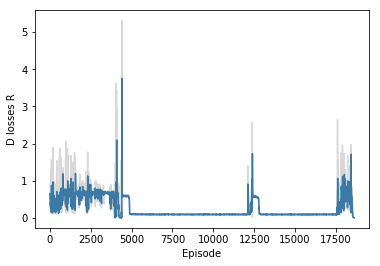

In [207]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

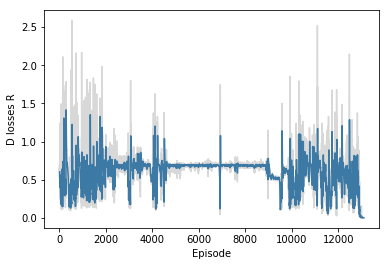

In [191]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

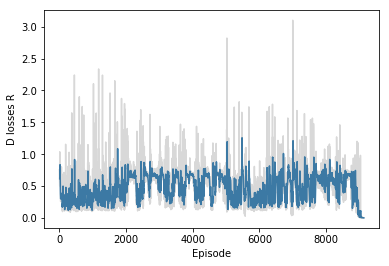

In [168]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

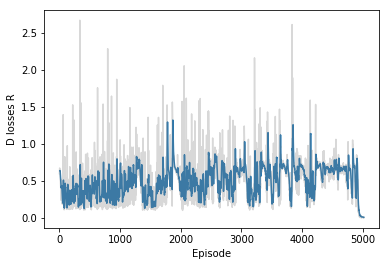

In [131]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

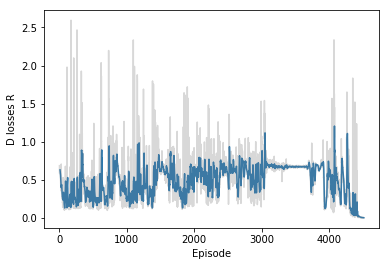

In [112]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

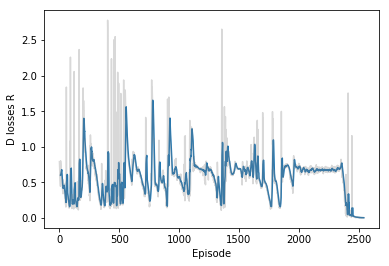

In [87]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

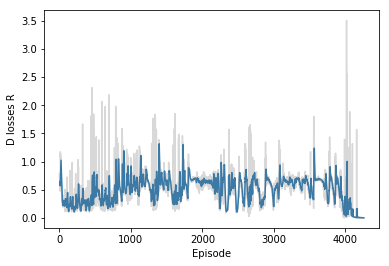

In [67]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

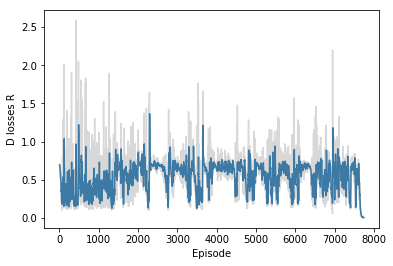

In [47]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

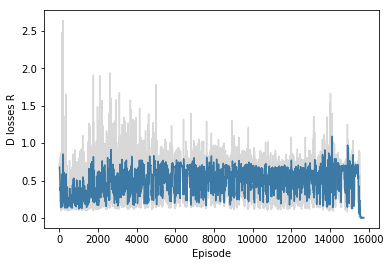

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

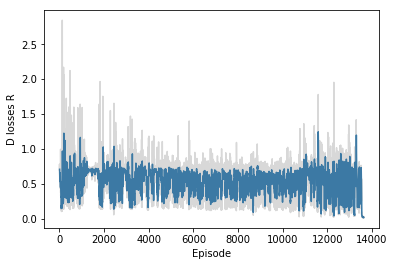

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

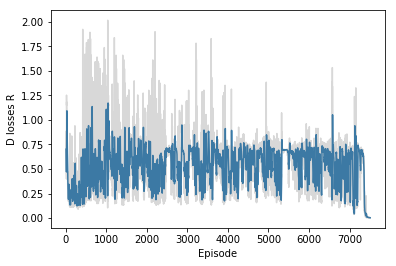

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

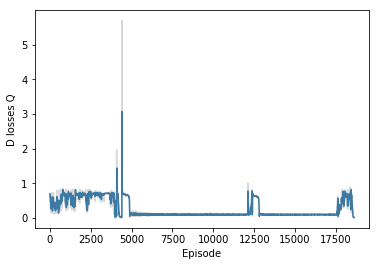

In [208]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

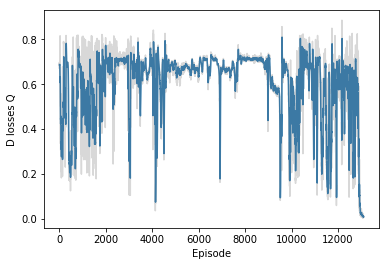

In [192]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

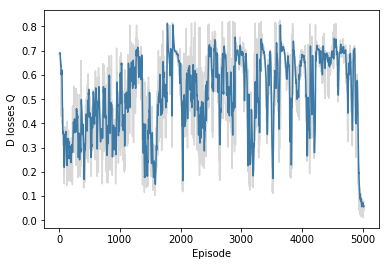

In [132]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

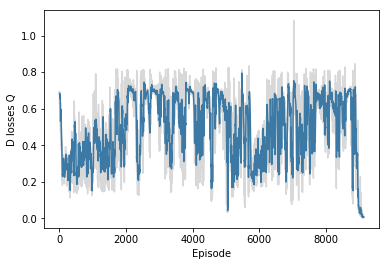

In [169]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

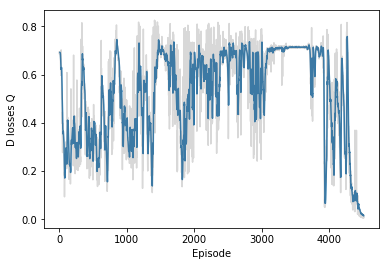

In [113]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

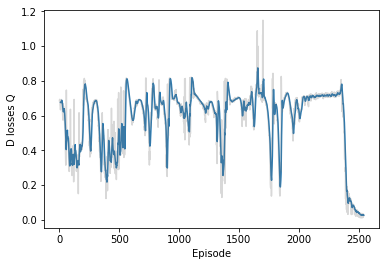

In [88]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

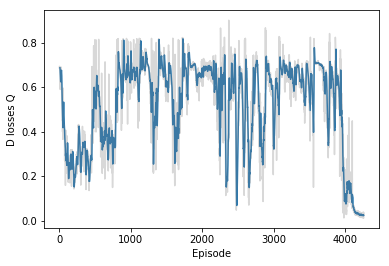

In [68]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

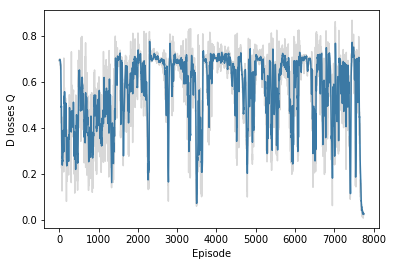

In [48]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

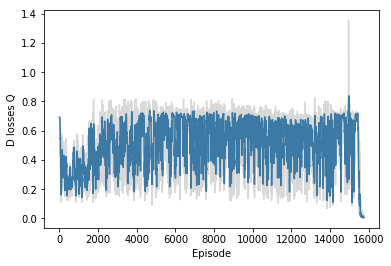

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

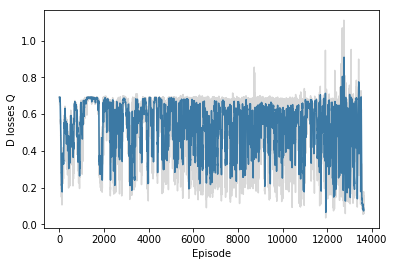

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

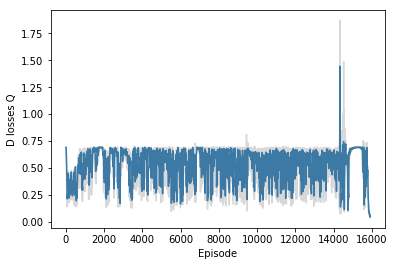

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

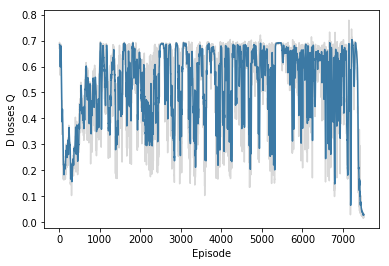

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.